<a href="https://colab.research.google.com/github/pearcej/complex/blob/master/chap02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Algorithms

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2017 Allen Downey, [MIT License](https://opensource.org/licenses/MIT)

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import os
if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py
import string

from utils import decorate, savefig

### Empirical order of growth

Sometimes we can figure out what order of growth a function belongs to by running it with a range of problem sizes and measuring the run time.

To measure runtimes, we'll use `etime`, which uses `os.times` to compute the total time used by a process, including "user time" and "system time".  User time is time spent running your code; system time is time spent running operating system code on your behalf.

In [4]:
def etime():
    """Measures user and system time this process has used.

    Returns the sum of user and system time."""
    user, sys, chuser, chsys, real = os.times()
    return user+sys

`time_func` takes a function object and a problem size, `n`, runs the function, and returns the elapsed time.

In [5]:
def time_func(func, n):
    """Run a function and return the elapsed time.
    
    func: function
    n: problem size
    
    returns: user+sys time in seconds
    """
    start = etime()
    func(n)
    end = etime()
    elapsed = end - start
    return elapsed

Here's an example: a function that makes a list with the given length using `append`.

In [6]:
def append_list(n):
    t = []
    for i in range(n):
        t.append(i)
    return t

time_func(append_list, 1000000)

0.1299999999999999

`run_timing_test` takes a function, runs it with a range of problem sizes, and returns two lists: problem sizes and times.

In [7]:
def run_timing_test(func, max_time=1):
    """Tests the given function with a range of values for n.
    
    func: function object

    returns: list of ns and a list of run times.
    """
    ns = []
    ts = []
    for i in range(10, 28):
        n = 2**i
        t = time_func(func, n)
        print(n, t)
        if t > 0:
            ns.append(n)
            ts.append(t)
        if t > max_time:
            break

    return ns, ts

Here's an example with `append_list`

In [8]:
ns, ts = run_timing_test(append_list)

1024 0.0
2048 0.009999999999999787
4096 0.0
8192 0.0
16384 0.0
32768 0.0
65536 0.010000000000000231
131072 0.020000000000000018
262144 0.020000000000000018
524288 0.06000000000000005
1048576 0.10999999999999988
2097152 0.23999999999999977
4194304 0.4700000000000002
8388608 0.9699999999999998
16777216 1.92


`fit` takes the lists of ns and ts and fits it with a curve of the form `a * n**exp`, where `exp` is a given exponent and `a` is chosen so that the line goes through a particular point in the sequence, usually the last. 

In [9]:
def fit(ns, ts, exp=1.0, index=-1):
    """Fits a curve with the given exponent.
    
    ns: sequence of problem sizes
    ts: sequence of times
    exp: exponent of the fitted curve
    index: index of the element the fitted line should go through
    
    returns: sequence of fitted times

    
    """
    # Use the element with the given index as a reference point, 
    # and scale all other points accordingly.
    nref = ns[index]
    tref = ts[index]

    tfit = []
    for n in ns:
        ratio = n / nref
        t = ratio**exp * tref
        tfit.append(t)

    return tfit

`plot_timing_test` plots the results.

In [10]:
def plot_timing_test(ns, ts, label='', color='blue', exp=1.0, scale='log'):
    """Plots data and a fitted curve.

    ns: sequence of n (problem size)
    ts: sequence of t (run time)
    label: string label for the data curve
    color: string color for the data curve
    exp: exponent (slope) for the fitted curve
    """
    tfit = fit(ns, ts, exp)
    fit_label = 'exp = %d' % exp
    plt.plot(ns, tfit, label=fit_label, color='0.7', linestyle='dashed')
    plt.plot(ns, ts, 'o-', label=label, color=color, alpha=0.7)
    plt.xlabel('Problem size (n)')
    plt.ylabel('Runtime (seconds)')
    plt.xscale(scale)
    plt.yscale(scale)
    plt.legend()

Here are the results from `append_list`.  When we plot `ts` versus `ns` on a log-log scale, we should get a straight line.  If the order of growth is linear, the slope of the line should be 1. 

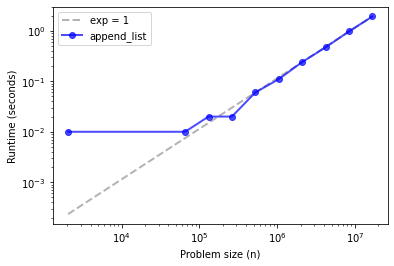

In [11]:
plot_timing_test(ns, ts, 'append_list', exp=1)

For small values of `n`, the runtime is so short that we're probably not getting an accurate measurement of just the operation we're interested in.  But as `n` increases, runtime seems to converge to a line with slope 1.  

That suggests that performing append `n` times is linear, which suggests that a single append is constant time.  

### list.pop

Now let's try that with `pop`, and specifically with `pop(0)`, which pops from the left side of the list.

1024 0.0
2048 0.0
4096 0.009999999999999787
8192 0.009999999999999787
16384 0.020000000000000462
32768 0.10999999999999943
65536 0.3799999999999999
131072 1.5000000000000009


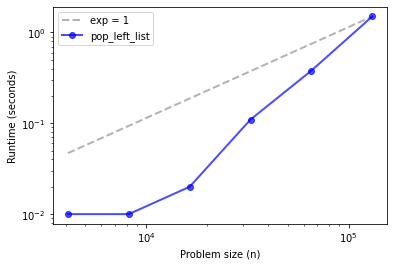

In [12]:
def pop_left_list(n):
    t= []
    for i in range(n):
        t.append(i)
    for _ in range(n):
        t.pop(0)
    return t

ns, ts = run_timing_test(pop_left_list)
plot_timing_test(ns, ts, 'pop_left_list', exp=1)

That doesn't look very good.  The runtimes increase more steeply than the line with slope 1.  Let's try slope 2.

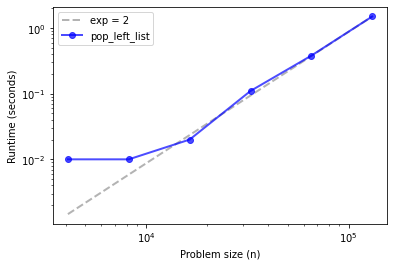

In [13]:
plot_timing_test(ns, ts, 'pop_left_list', exp=2)

The last few points converge on the line with slope 2, which suggests that `pop(0)` is quadratic.

**Exercise:**  What happens if you pop from the end of the list?  Write a function called `pop_right_list` that pops the last element instead of the first.  Use `run_timing_test` to characterize its performance.  Then use `plot_timing_test` with a few different values of `exp` to find the slope that best matches the data.  What conclusion can you draw about the order of growth for popping an element from the end of a list?

In [14]:
# Solution goes here

### Sorting

We expect sorting to be `n log n`.  On a log-log scale, that doesn't look like a straight line, so there's no simple test whether it's really `n log n`.  Nevertheless, we can plot results for sorting lists with different lengths, and see what it looks like.

1024 0.0
2048 0.0
4096 0.0
8192 0.0
16384 0.0
32768 0.010000000000001563
65536 0.0
131072 0.019999999999999574
262144 0.019999999999999574
524288 0.0600000000000005
1048576 0.11999999999999922
2097152 0.25
4194304 0.5099999999999998
8388608 1.0700000000000003


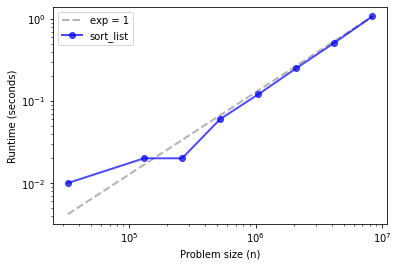

In [15]:
def sort_list(n):
    t = np.random.random(n)
    t.sort()
    return t

ns, ts = run_timing_test(sort_list)
plot_timing_test(ns, ts, 'sort_list', exp=1)

It sure looks like sorting is linear, so that's surprising.  But remember that `log n` changes much more slowly than `n`.  Over a wide range of values, `n log n` can be hard to distinguish from an algorithm with linear growth.  As `n` gets bigger, we would expect this curve to be steeper than slope 1.  But often, for practical problem sizes, `n log n` is as good as linear.

### Bisection search

We expect bisection search to be `log n`, which is so fast it is hard to measure the way we've been doing it.

To make it work, I create the sorted list ahead of time and use the parameter `hi` to specify which part of the list to search.  Also, I have to run each search 100,000 times so it takes long enough to measure. 

1024 0.19000000000000128
2048 0.21999999999999886


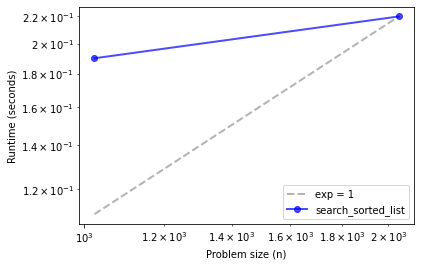

In [16]:
t = np.random.random(16777216)
t.sort()

from bisect import bisect

def search_sorted_list(n):
    for i in range(100000):
        index = bisect(t, 0.1, hi=n) 
    return index

ns, ts = run_timing_test(search_sorted_list, max_time=0.2)
plot_timing_test(ns, ts, 'search_sorted_list', exp=1)

It looks like the runtime increases slowly as `n` increases, but it's definitely not linear.  To see if it's constant time, we can compare it to the line with slope 0.

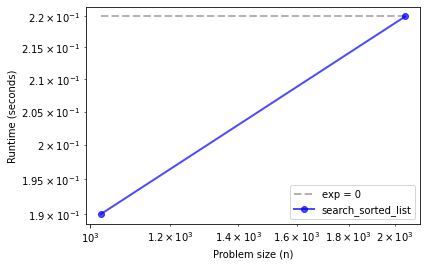

In [17]:
plot_timing_test(ns, ts, 'search_sorted_list', exp=0)

Nope, looks like it's not constant time, either.  We can't really conclude that it's `log n` based on this curve alone, but the results are certainly consistent with that theory.

### Dictionary methods

**Exercise:** Write methods called `add_dict` and `lookup_dict`, based on `append_list` and `pop_left_list`.  What is the order of growth for adding and looking up elements in a dictionary?

In [18]:
# Solution goes here

In [19]:
# Solution goes here

In [20]:
# Solution goes here

### Implementing a hash table

The reason Python dictionaries can add and look up elements in constant time is that they are based on hash tables.  In this section, we'll implement a hash table in Python.  Remember that this example is for educational purposes only.  There is no practical reason to write a hash table like this in Python.

We'll start with a simple linear map, which is a list of key-value pairs.

In [21]:
class LinearMap(object):
    """A simple implementation of a map using a list of tuples
    where each tuple is a key-value pair."""

    def __init__(self):
        self.items = []

    def add(self, k, v):
        """Adds a new item that maps from key (k) to value (v).
        Assumes that they keys are unique."""
        self.items.append((k, v))

    def get(self, k):
        """Looks up the key (k) and returns the corresponding value,
        or raises KeyError if the key is not found."""
        for key, val in self.items:
            if key == k:
                return val
        raise KeyError

First let's make sure it works:

In [22]:
def test_map(m):
    s = string.ascii_lowercase

    for k, v in enumerate(s):
        m.add(k, v)

    for k in range(len(s)):
        print(k, m.get(k))

In [23]:
m = LinearMap()
test_map(m)

0 a
1 b
2 c
3 d
4 e
5 f
6 g
7 h
8 i
9 j
10 k
11 l
12 m
13 n
14 o
15 p
16 q
17 r
18 s
19 t
20 u
21 v
22 w
23 x
24 y
25 z


Now let's see how long it takes to add `n` elements.

1024 0.0
2048 0.0
4096 0.0
8192 0.0
16384 0.00999999999999801
32768 0.010000000000001563
65536 0.030000000000001137
131072 0.03999999999999915
262144 0.08999999999999986
524288 0.17999999999999972
1048576 0.33999999999999986
2097152 0.6900000000000013
4194304 1.3399999999999999


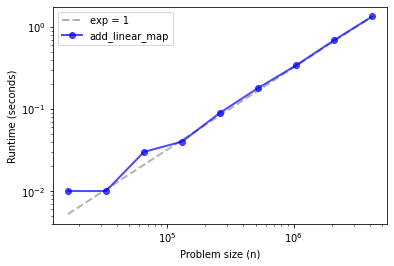

In [24]:
def add_linear_map(n):
    d = LinearMap()
    for i in range(n):
        d.add(i, 1)
    return d

ns, ts = run_timing_test(add_linear_map)
plot_timing_test(ns, ts, 'add_linear_map', exp=1)

Adding `n` elements is linear, so each add is constant time.  How about lookup?

1024 0.030000000000001137
2048 0.0799999999999983
4096 0.3200000000000003
8192 1.360000000000003


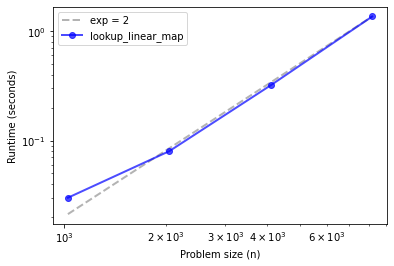

In [25]:
def lookup_linear_map(n):
    d = LinearMap()
    for i in range(n):
        d.add(i, 1)
    total = 0
    for i in range(n):
        total += d.get(i)
    return d

ns, ts = run_timing_test(lookup_linear_map)
plot_timing_test(ns, ts, 'lookup_linear_map', exp=2)

Looking up `n` elements is $O(n^2)$ (notice that `exp=2`).  So each lookup is linear.

Let's see what happens if we break the list of key-value pairs into 100 lists.

In [26]:
class BetterMap(object):
    """A faster implementation of a map using a list of LinearMaps
    and the built-in function hash() to determine which LinearMap
    to put each key into."""

    def __init__(self, n=100):
        """Appends (n) LinearMaps onto (self)."""
        self.maps = []
        for i in range(n):
            self.maps.append(LinearMap())

    def find_map(self, k):
        """Finds the right LinearMap for key (k)."""
        index = hash(k) % len(self.maps)
        return self.maps[index]

    def add(self, k, v):
        """Adds a new item to the appropriate LinearMap for key (k)."""
        m = self.find_map(k)
        m.add(k, v)

    def get(self, k):
        """Finds the right LinearMap for key (k) and looks up (k) in it."""
        m = self.find_map(k)
        return m.get(k)


In [27]:
m = BetterMap()
test_map(m)

0 a
1 b
2 c
3 d
4 e
5 f
6 g
7 h
8 i
9 j
10 k
11 l
12 m
13 n
14 o
15 p
16 q
17 r
18 s
19 t
20 u
21 v
22 w
23 x
24 y
25 z


The run time is better (we get to a larger value of `n` before we run out of time). 

1024 0.0
2048 0.010000000000001563
4096 0.00999999999999801
8192 0.030000000000001137
16384 0.10000000000000142
32768 0.41000000000000014
65536 1.5399999999999991


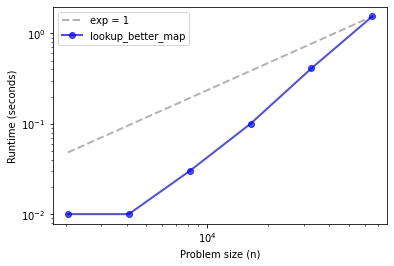

In [28]:
def lookup_better_map(n):
    d = BetterMap()
    for i in range(n):
        d.add(i, 1)
    total = 0
    for i in range(n):
        total += d.get(i)
    return d

ns, ts = run_timing_test(lookup_better_map)
plot_timing_test(ns, ts, 'lookup_better_map', exp=1)

The order of growth is hard to characterize.  It looks steeper than the line with slope 1.  Let's try slope 2.

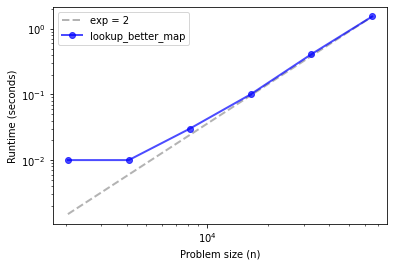

In [29]:
plot_timing_test(ns, ts, 'lookup_better_map', exp=2)

It might be converging to the line with slope 2, but it's hard to say anything conclusive without running larger problem sizes.

**Exercise:** Go back and run `run_timing_test` with a larger value of `max_time` and see if the run time converges to the line with slope 2.  Just be careful not to make `max_time` to big.

Now we're ready for a complete implementation of a hash map.

In [30]:
class HashMap(object):
    """An implementation of a hashtable using a BetterMap
    that grows so that the number of items never exceeds the number
    of LinearMaps.

    The amortized cost of add should be O(1) provided that the
    implementation of sum in resize is linear."""

    def __init__(self):
        """Starts with 2 LinearMaps and 0 items."""
        self.maps = BetterMap(2)
        self.num = 0

    def get(self, k):
        """Looks up the key (k) and returns the corresponding value,
        or raises KeyError if the key is not found."""
        return self.maps.get(k)

    def add(self, k, v):
        """Resize the map if necessary and adds the new item."""
        if self.num == len(self.maps.maps):
            self.resize()

        self.maps.add(k, v)
        self.num += 1

    def resize(self):
        """Makes a new map, twice as big, and rehashes the items."""
        new_map = BetterMap(self.num * 2)

        for m in self.maps.maps:
            for k, v in m.items:
                new_map.add(k, v)

        self.maps = new_map

In [31]:
m = HashMap()
test_map(m)

0 a
1 b
2 c
3 d
4 e
5 f
6 g
7 h
8 i
9 j
10 k
11 l
12 m
13 n
14 o
15 p
16 q
17 r
18 s
19 t
20 u
21 v
22 w
23 x
24 y
25 z


**Exercise:** Write a function called `lookup_hash_map`, based on `lookup_better_map`, and characterize its run time.

If things go according to plan, the results should converge to a line with slope 1.  Which means that `n` lookups is linear, which means that each lookup is constant time.  Which is pretty much magic.

In [32]:
# Solution goes here